# L0 Regularization

*05-03-2021*

This page contains my reading notes on 

- [**Learning Sparse Neural Networks through $L_{0}$ Regularization**](https://www.semanticscholar.org/paper/Learning-Sparse-Neural-Networks-through-L0-Louizos-Welling/572f5d18a3943dce4e14f937ef66977a01891096)

## Problem formulation

1. Given a vector $x$ of length $n$ (matrix can also be seen as a vector by stacking up the rows/cols), the common vector norms are:
    1. $L_{0}$ norm: $\sum_{i=1}^{n} \mathbb{1}[x_{i} \neq 0]$, where $\mathbb{1}[x_{i} \neq 0]$ means it evaluates to 1 if $x_{i} \neq 0$, 0 otherwise.
    1. $L_{1}$ norm: $\sum_{i=1}^{n} \lvert x_{i} \rvert$, which is also called ridge regularization in neural network.
    1. $L_{2}$ norm: $\sum_{i=1}^{n} x_{i}^2$, which is also called lasso regularization in neural network.
    1. $L_{\infty}$ norm: $\max_{i=1}^{n} \lvert x_i \rvert$.
1. The normal way to prune the edges of the neural network is to use $L_{1}$ or $L_{2}$ regularization to drive weights to near 0 (not exactly 0), and then directly set all weights that are less than threshold to 0.
    1. $L_{0}$ is not used because the operation of counting the number of 0s is not differentiable.

## General recipe of $L_{0}$ regularization

1. The loss function used to train a neural network with $L_{0}$ regularization is:
    $$ \mathcal{L}(f(x, \theta), y) + \lambda \sum_{i=1}^{\lvert \theta \rvert} \mathbb{1}[\theta_{i} \neq 0] $$
    where $\mathcal{L}$ is a standard loss function (cross-entropy loss, softmax), $\theta$ are the parameters in the network, $h(\cdot, \theta)$ is the network, $x, y$ are training instances and $\lambda$ is a hyper-parameter that balance loss and the regularization. 
1. If we attach a **binary random variable** $z_{i}$ to each element of the model parameter $\theta_{i}$, then the weights used in the feed-forward operation of the neural network can be replaced by $\theta \odot z$. The loss function then becomes:
    $$ \mathcal{L}(f(x, \theta \odot z), y) + \lambda \sum_{i=1}^{\lvert \theta \rvert} \mathbb{1}[z_{i} \neq 0]$$
    where $z \in \{0, 1\}^{\lvert \theta \rvert}$.
1. If we assume each $z_{i}$ as a binary random variable with a **Bernoulli distribution** that has a parameter $\pi_{i}$, i.e. $z_{i} = \mathrm{Bern}(\pi_{i})$, then the loss function becomes:
    $$ \mathbb{E}_{z=\mathrm{Bern}(\pi)} \big[ \mathcal{L}(f(x, \theta \odot z), y) \big] + \lambda \sum_{i=1}^{\lvert \theta \rvert} \pi_{i} $$
    where $\mathbb{E}_{z=\mathrm{Bern}(\pi)} [\cdot]$ gives an expectation value of a function that has a Bernoulli distribution $z$ as the input. 
1. The reformulation of the above loss function can be established because
    1. Since the minimum of a function is upper bounded by the expectation of the function, minimizing $\mathbb{E}_{z=\mathrm{Bern}(\pi)} \big[ \mathcal{L}(f(x, \theta \odot z), y) \big]$ is the same as minimizing the upper bound of $\mathcal{L}(f(x, \theta \odot z), y)$.
    1. According to the definition of the Bernoulli distribution, $\pi$ gives the probability of $z$ being 1. Thus, minimizing $\pi$ is to increase the probability of $z$ being 0.
1. In the equation above, the second term is very easy to minimize, but the first term is still problematic because Bernoulli distribution is a discrete distribution that has 0 gradient almost everywhere. The two $L_{0}$ regularization methods below approximates the Bernoulli distribution with two different continuous distributions.

## Hard concrete distribution
1. Assume that we have a new random variable $s$ that has a **continuous distribution** with a parameter $\phi$.
    1. Assume that the continuous distribution has a range from less than 0 to larger than 1, i.e. [-0.5, 1.5]. 
        $$ s \sim \textrm{q}(s | \phi) \in [-0.5, 1.5] $$
        where $\textrm{q}(\cdot)$ is the probability density function (PDF).
    1. In this case, the probability of the variable $s$ being positive can be easily calculated by subtracting the probability of $s$ being negative from 1 (the total probability):
        $$ \textrm{q}(s > 0 | \phi) = 1 - \mathrm{Q}(s \leq 0 | \phi) $$
        where $\textrm{Q}(\cdot)$ is the cumulative density function (CDF) and $\mathrm{Q}(s \leq 0 | \phi)$ gives the probability of $s$ being negative.
    1. If we clip the distribution into the range of [0, 1], then we can use the clipped version of the continuous distribution to replace $z$.
        $$ z = \mathrm{clip}(s, 0, 1) $$
        where $\mathrm{clip}(x, \mathrm{min}, \mathrm{max})$ means to clip $x$ between the range $[\mathrm{min}, \mathrm{max}]$. 
    1. After clipping, the probability of the variable $s$ being positive is the same as the probability of $z$ being non-zero. Thus, the loss function above can be rewritten using $s$ by:
        $$ \mathbb{E}_{s \sim \textrm{q}(s | \phi)} \big[ \mathcal{L}(f(x, \theta \odot \mathrm{clip}(s, 0, 1)), y) \big] + \lambda \sum_{i=1}^{\lvert \theta \rvert} (1 - \mathrm{Q}(s \leq 0 | \phi)) $$
1. Hard concrete distribution is a slight modification version of [binary concrete](https://vitalab.github.io/article/2018/11/29/concrete.html) random variable.
    1. TODO

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
plt.style.use("ggplot")

interactive(children=(FloatSlider(value=0.0, description='loc', max=0.5, min=-0.5), FloatSlider(value=0.505, d…

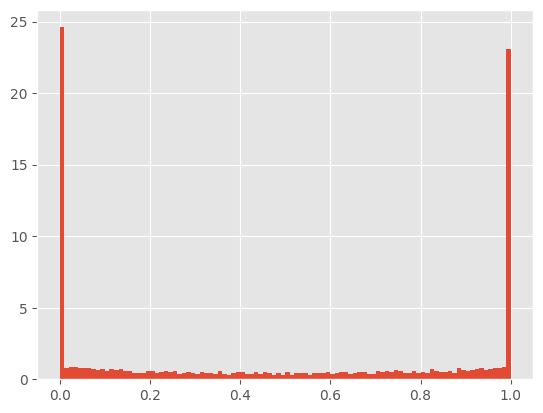

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def hard_sigmoid(x):
    return min(1, max(0, x))

def hard_concrete(loc, temp, gamma, zeta):
    u = np.random.random()
    s = sigmoid((np.log(u) - np.log(1 - u) + loc) / temp)
    s = s * (zeta - gamma) + gamma
    return hard_sigmoid(s)

def plot_hard_concreate(loc, temp, gamma, zeta, num=10_000, bins=100, **kwargs):
    plt.hist([hard_concrete(loc, temp, gamma, zeta) for _ in range(num)], bins=bins, density=True, **kwargs)
    
def interactive_hard_concrete(loc, temp):
    plot_hard_concreate(loc, temp, gamma=-0.1, zeta=1.1)

interact(interactive_hard_concrete, loc=(-0.5, 0.5), temp=(0.01, 1));